In [15]:
%pip install numpy pandas seaborn matplotlib scikit-learn plotly kagglehub

Note: you may need to restart the kernel to use updated packages.


In [16]:
# =========================================================
# fonte_final_cmp263_final.py - CMP263: Previsão de Vendas Amazon
# Projeto Final: Aplicação de Boas Práticas em Machine Learning
# Dataset: amazon_products_sales_data_cleaned.csv
# Autores: Joice da Silva Reginaldo, Henrique Krausburg Correa
# =========================================================

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from kagglehub import dataset_download


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Tentar importar Plotly

try:
    import plotly.graph_objs as go
    import plotly.express as px
    PLOTLY_AVAILABLE = True
    print("[INFO] Plotly disponível: gráficos interativos habilitados.")

except ModuleNotFoundError:
    PLOTLY_AVAILABLE = False
    print("[INFO] Plotly não encontrado: gráficos interativos desabilitados.")


[INFO] Plotly disponível: gráficos interativos habilitados.


In [17]:

# =========================
# Configuração de caminhos
# =========================

SCRIPT_DIR = os.getcwd()
DATASET_PATH = dataset_download("ikramshah512/amazon-products-sales-dataset-42k-items-2025", path="amazon_products_sales_data_cleaned.csv")
OUTPUT_DIR = os.path.join(SCRIPT_DIR, "Result")
os.makedirs(OUTPUT_DIR, exist_ok=True)
HTML_REPORT_TECH = os.path.join(OUTPUT_DIR, "relatorio_tecnico_final.html")
HTML_REPORT_USER = os.path.join(OUTPUT_DIR, "relatorio_simplificado_final.html")


In [18]:

# =========================
# Funções auxiliares
# =========================

def safe_plot(plot_func, *args, **kwargs):
    """Exibe um gráfico Matplotlib no notebook."""
    try:
        plot_func(*args, **kwargs)
        plt.show()  # Exibe o gráfico no notebook
        plt.close()
    except Exception as e:
        print(f"[ERRO] Não foi possível gerar o gráfico: {e}")
        plt.close()

def plot_predictions_interactive(y_true, y_pred, output_file):
    """Gera gráfico interativo Plotly ou estático Matplotlib das previsões."""

    if PLOTLY_AVAILABLE:
        fig = go.Figure()
        # Usar um subconjunto para Plotly se o dataset for muito grande
        sample_size = min(len(y_true), 1000)
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        fig.add_trace(go.Scatter(y=y_true.iloc[indices], mode='lines+markers', name='Real'))
        fig.add_trace(go.Scatter(y=y_pred[indices], mode='lines+markers', name='Predito'))
        fig.update_layout(
            title="Previsões x Valores Reais (Amostra)",
            xaxis_title="Índice", yaxis_title="Vendas")
        fig.write_html(output_file)
        print(f"[INFO] Gráfico interativo Plotly salvo em {output_file}")
    else:
        plt.figure(figsize=(10,6))
        plt.plot(y_true.values, marker='o', label='Real')
        plt.plot(y_pred, marker='x', label='Predito')
        plt.title("Previsões x Valores Reais")
        plt.xlabel("Índice")
        plt.ylabel("Vendas")
        plt.legend()
        plt.tight_layout()
        plt.savefig(output_file.replace(".html", ".png"))
        plt.close()
        print(f"[INFO] Gráfico Matplotlib salvo em {output_file.replace(".html", ".png")}")
        
def truncate_feature_name(name, max_length=60):
    """Trunca nomes de features longos, preservando o início."""
    if len(name) <= max_length:
        return name
    return name[:max_length-3] + '...'


In [19]:
# =========================
# Carregar dataset
# =========================

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Arquivo CSV não encontrado: {DATASET_PATH}")


print("🔹  Carregando dataset...")
df = pd.read_csv(DATASET_PATH)


🔹  Carregando dataset...


In [20]:
# =========================
# (i) Análise exploratória dos dados (Antes do Pré-processamento)
# =========================

# 1. Remoção de linhas com valor alvo ausente (Crítica: Nunca mexer no valor do campo alvo)

# Para um problema de regressão, não podemos imputar o valor alvo.
target = "purchased_last_month"
df.dropna(subset=[target], inplace=True)
print(f" Dataset carregado após remover {target} ausentes: {df.shape[0]} linhas e {df.shape[1]} colunas.")

desc_stats = df.describe(include='all').to_html()
missing_data = df.isnull().sum().to_dict()
missing_data_html = "<ul>" + "".join([f"<li>{k}: {v}</li>" for k, v in missing_data.items() if v > 0]) + "</ul>"

# Identificar colunas para diferentes tipos de pré-processamento
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remover o target da lista de colunas numéricas para análise
if target in num_cols:
    num_cols.remove(target)

# Identificar colunas categóricas (object) que não são identificadores/textos longos
# Assumindo que 'category' é a única categórica nominal útil.
# 'product_id', 'title', 'date_added' são considerados para descarte ou tratamento especial.
cat_cols = ['category']

# Colunas a serem descartadas ou tratadas com métodos mais avançados (fora do escopo desta correção simples)
cols_to_drop = ['product_image_url', 'product_title', 'data_collected_at', 'data_collected_at', 'product_page_url']


 Dataset carregado após remover purchased_last_month ausentes: 32164 linhas e 17 colunas.


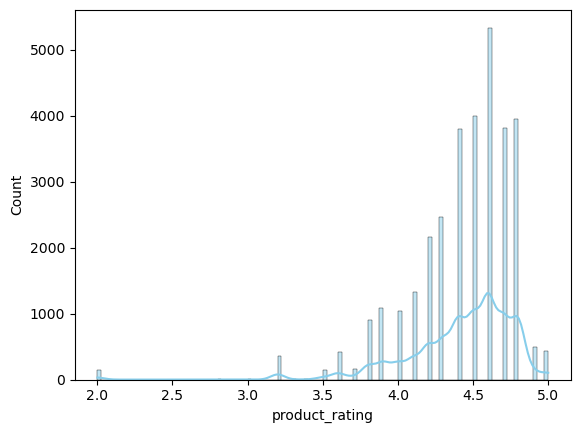

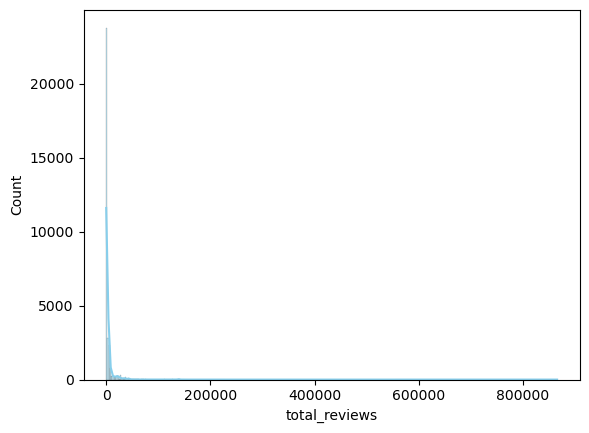

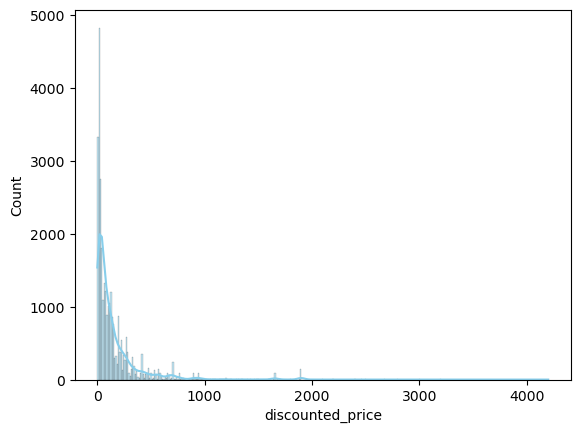

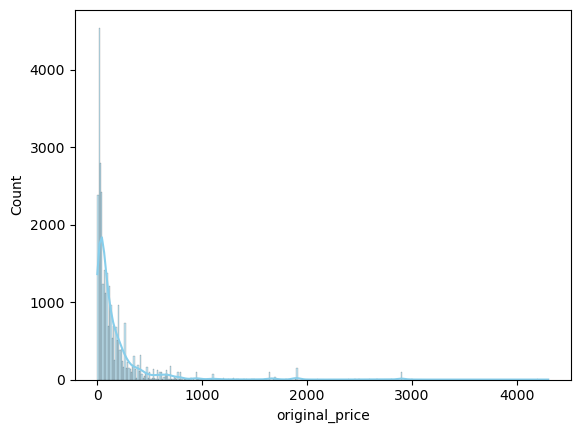

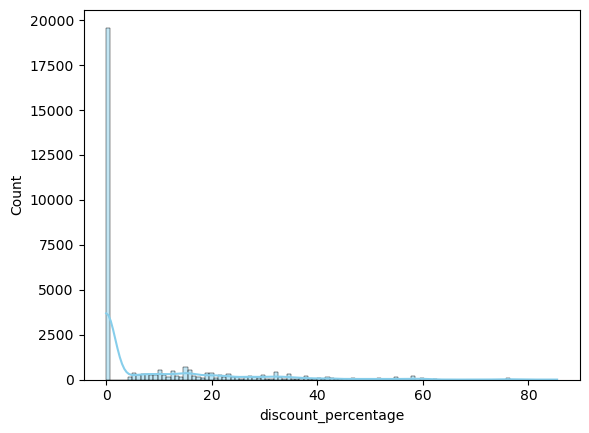

In [21]:
# Histogramas das variáveis numéricas (Apenas para as colunas numéricas que não são o target)
for col in num_cols:
    safe_plot(lambda: sns.histplot(df[col], kde=True, color='skyblue'))


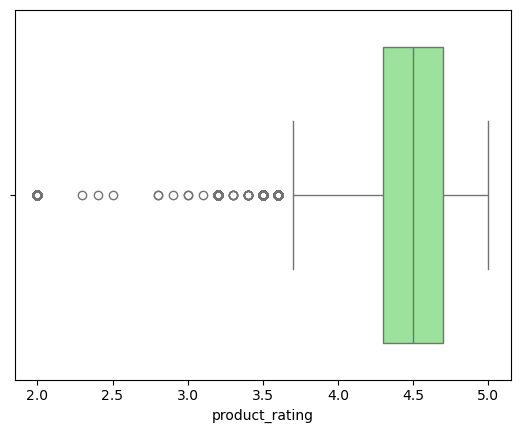

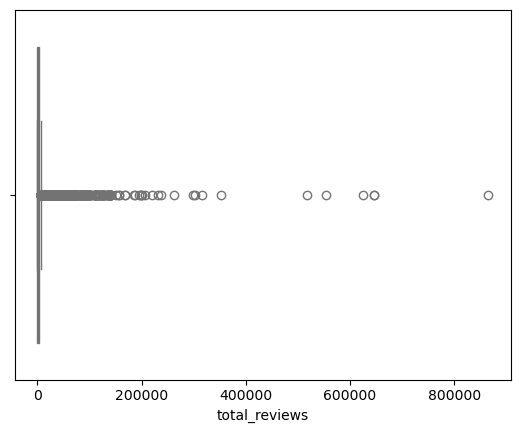

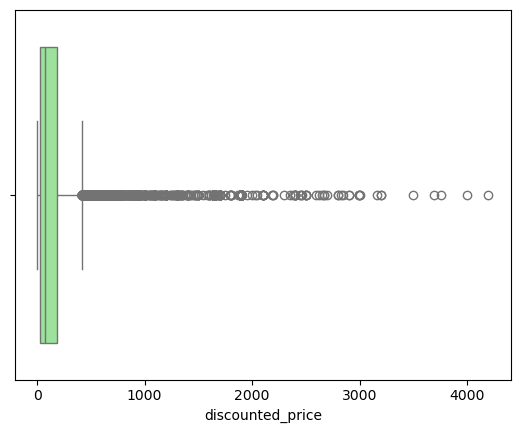

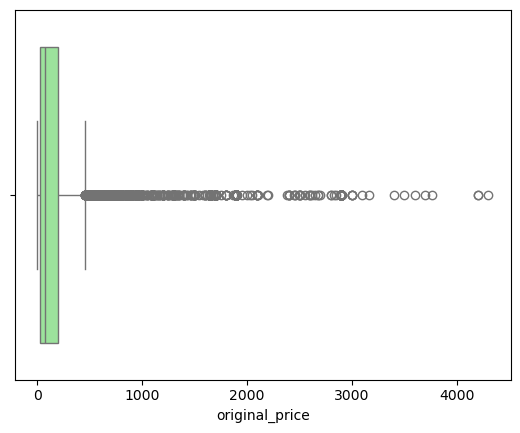

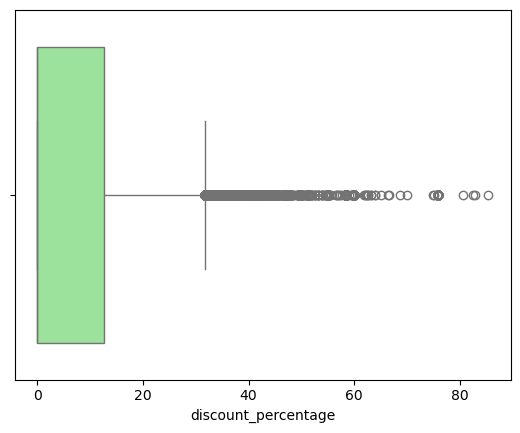

In [22]:
# Boxplots para detecção de outliers
for col in num_cols:
    safe_plot(lambda: sns.boxplot(x=df[col], color='lightgreen'))


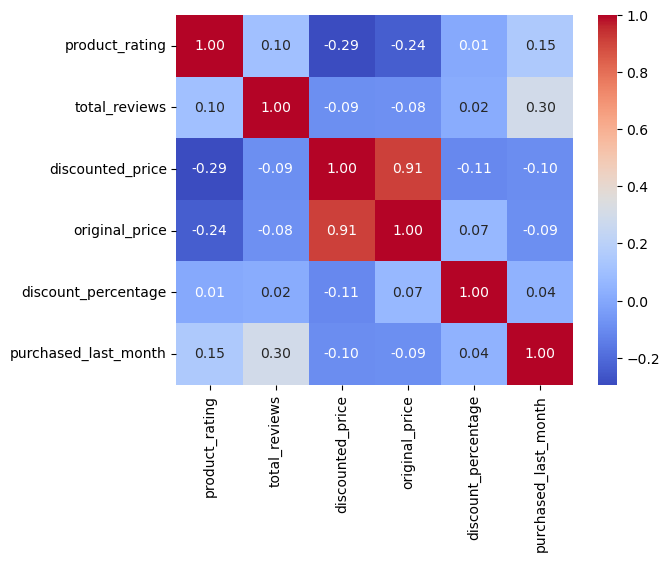

In [23]:
# Heatmap de correlação (apenas numéricas)
all_num_cols = num_cols + [target]
safe_plot(lambda: sns.heatmap(df[all_num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm"))

In [24]:
# =========================
# (ii) Pré-processamento dos dados (Uso de Pipeline e ColumnTransformer)
# =========================
# Separação de X e y
# Garante que apenas colunas que existem no DataFrame sejam incluídas na lista de descarte
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=[target] + existing_cols_to_drop)
y = df[target]

# Separação de treino e teste (Pré-processamento só pode ser feito após o split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definição dos transformadores para o ColumnTransformer
# 1. Numéricas: Imputação por Mediana (menos sensível a outliers que a média) e Scaling
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categóricas: Imputação por valor mais frequente e One-Hot Encoding
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criação do pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter colunas não processadas (ex: date_added se não for descartada)
)


In [25]:
# =========================
# (iii) Treinamento e validação dos modelos (Uso de Pipeline)
# =========================

models_raw = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Removido XGBoost para manter o foco nos modelos principais do curso
results = {}
best_model_name = ""
best_r2 = -np.inf

for name, model in models_raw.items():
    # Criação do Pipeline: Pré-processamento + Modelo
    full_pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
    
    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "model": full_pipeline,
        "y_pred": y_pred,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2
    }

    print(f" {name} avaliado: MAE={results[name]["MAE"]:.2f}, RMSE={results[name]["RMSE"]:.2f}, R2={results[name]["R2"]:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_model_name = name

# Otimização RandomForest (Exemplo de GridSearch com Pipeline)
# Nota: O GridSearch deve ser aplicado ao Pipeline completo para evitar vazamento.
print("\n🔹  Otimizando o melhor modelo (RandomForest, se disponível)...")
if "RandomForest" in models_raw:
    rf_pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
        ]
    )

    # Otimização de hiperparâmetros (reduzida para agilizar)
    param_grid = {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [5, 10]
    }

    grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_rf_pipeline = grid.best_estimator_
    y_pred_best_rf = best_rf_pipeline.predict(X_test)

    # Atualiza resultados com o modelo otimizado
    results["RandomForest_Otimizado"] = {
        "model": best_rf_pipeline,
        "y_pred": y_pred_best_rf,
        "MAE": mean_absolute_error(y_test, y_pred_best_rf),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_best_rf)),
        "R2": r2_score(y_test, y_pred_best_rf)
    }
    print(f"🔹  RandomForest otimizado: R2={results["RandomForest_Otimizado"]["R2"]:.4f}")

    # Se o otimizado for melhor, ele se torna o "melhor modelo" para relatórios
    if results["RandomForest_Otimizado"]["R2"] > best_r2:
        best_r2 = results["RandomForest_Otimizado"]["R2"]
        best_model_name = "RandomForest_Otimizado"
        

best_model_result = results[best_model_name]
best_model = best_model_result["model"]
y_pred_best = best_model_result["y_pred"]
best_model_preprocessor = best_model.named_steps['preprocessor']
best_model_regressor = best_model.named_steps['regressor']


 LinearRegression avaliado: MAE=1761.26, RMSE=4846.21, R2=0.2856
 RandomForest avaliado: MAE=267.06, RMSE=1936.68, R2=0.8859
 GradientBoosting avaliado: MAE=458.40, RMSE=1856.27, R2=0.8952

🔹  Otimizando o melhor modelo (RandomForest, se disponível)...
🔹  RandomForest otimizado: R2=0.8848



🔹 Top 20 Features mais importantes:

                                                feature  importance
                                     num__total_reviews    0.640929
                cat__product_category_Power & Batteries    0.177381
                            cat__is_sponsored_Sponsored    0.039097
                          cat__delivery_date_2025-08-29    0.024113
                                  num__discounted_price    0.019769
                                    num__original_price    0.019515
                              cat__is_sponsored_Organic    0.018493
                                    num__product_rating    0.017542
                        cat__is_best_seller_Best Seller    0.011824
                cat__product_category_Other Electronics    0.006732
                               num__discount_percentage    0.005460
       cat__sustainability_tags_Safer chemicals +1 more    0.005097
                        cat__product_category_Wearables    0.003350
cat__susta

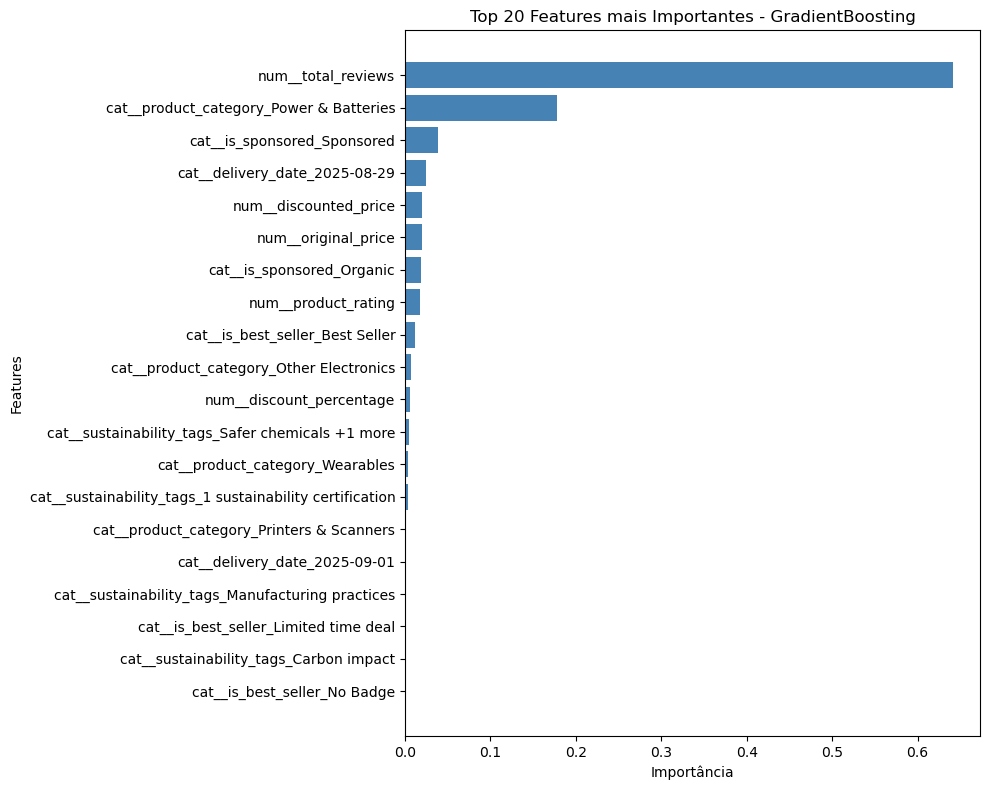

In [26]:
# =========================
# (iv) Interpretação e análise crítica
# =========================

feature_importances = pd.DataFrame()
# Feature importance só é aplicável a modelos baseados em árvore como RandomForest

# Obter nomes das features após o OneHotEncoding
# Nota: get_feature_names_out é o método correto para ColumnTransformer
raw_feature_names = best_model_preprocessor.get_feature_names_out()
processed_feature_names = [truncate_feature_name(name) for name in raw_feature_names]

# Criar DataFrame com importâncias
feature_importances = pd.DataFrame({
    'feature': processed_feature_names,
    'importance': best_model_regressor.feature_importances_
}).sort_values('importance', ascending=False)

# Plot das top 5 features
top_n = 20
print(f"\n🔹 Top {top_n} Features mais importantes:\n")
print(feature_importances.head(top_n).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importances.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title(f'Top {top_n} Features mais Importantes - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot interativo com Plotly (se disponível)
if PLOTLY_AVAILABLE:
    fig = px.bar(
        feature_importances.head(top_n),
        x='importance',
        y='feature',
        orientation='h',
        title=f'Top {top_n} Features mais Importantes - {best_model_name}',
        labels={'importance': 'Importância', 'feature': 'Feature'}
    )
    fig.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
else:
    print(f"\n[INFO] Feature importance não disponível para {best_model_name}")
    print("[INFO] Este recurso está disponível apenas para modelos baseados em árvore (RandomForest, GradientBoosting)")


🔹 Gerando gráfico de dispersão para GradientBoosting...


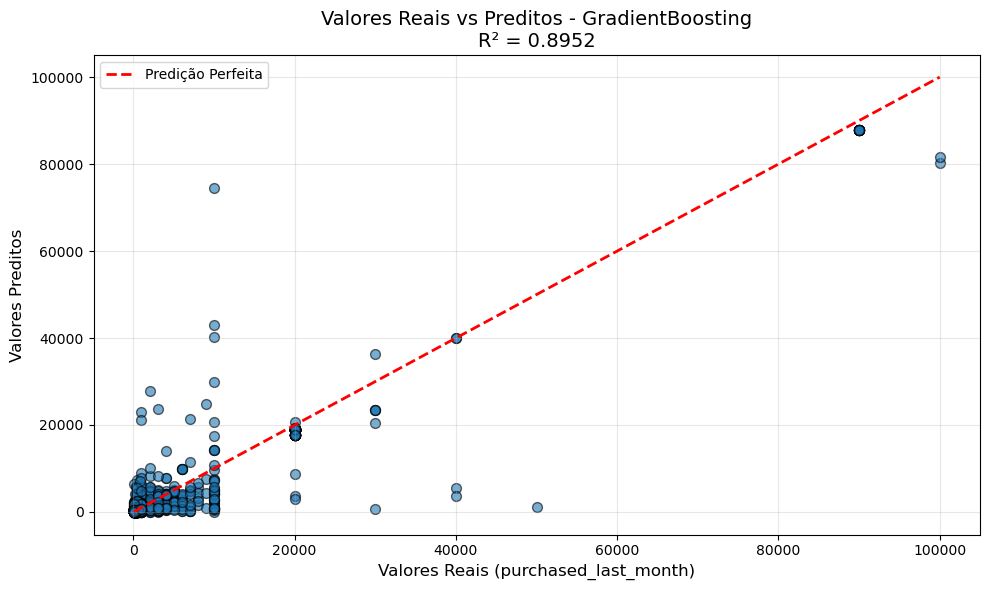

In [27]:
# =========================
# Visualizações de Regressão - Gráfico de Dispersão
# =========================

# 1. Scatter Plot: Valores Reais vs Preditos (Melhor Modelo)
print(f"\n🔹 Gerando gráfico de dispersão para {best_model_name}...")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, edgecolors='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predição Perfeita')
plt.xlabel('Valores Reais (purchased_last_month)', fontsize=12)
plt.ylabel('Valores Preditos', fontsize=12)
plt.title(f'Valores Reais vs Preditos - {best_model_name}\nR² = {best_r2:.4f}', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

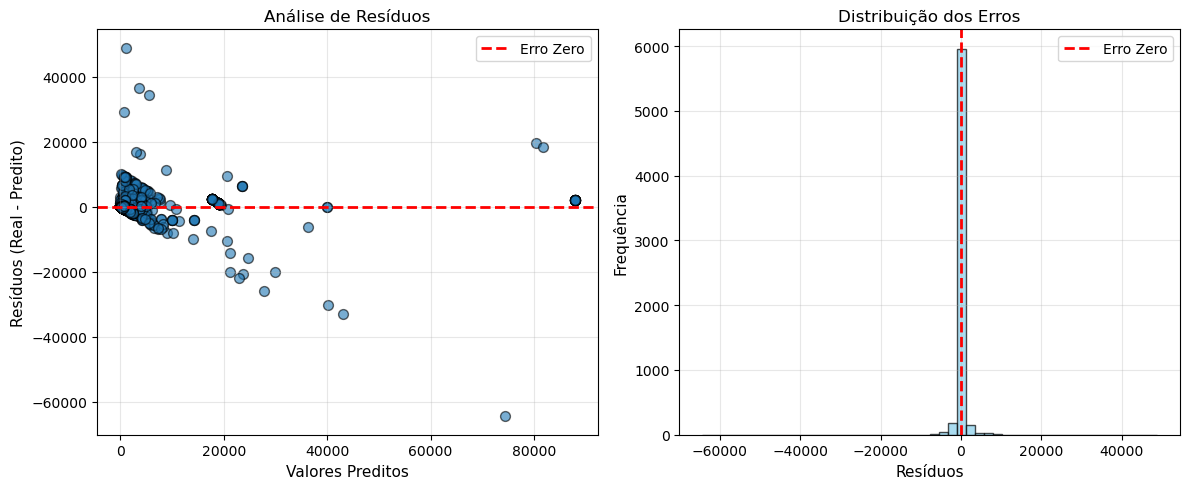


📊 Estatísticas dos Resíduos:
   Média: -31.70
   Desvio Padrão: 1856.14
   Min: -64413.22 | Max: 48843.18


In [28]:
# 2. Análise de Resíduos
residuos = y_test - y_pred_best

plt.figure(figsize=(12, 5))

# Subplot 1: Resíduos vs Valores Preditos
plt.subplot(1, 2, 1)
plt.scatter(y_pred_best, residuos, alpha=0.6, edgecolors='k', s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Erro Zero')
plt.xlabel('Valores Preditos', fontsize=11)
plt.ylabel('Resíduos (Real - Predito)', fontsize=11)
plt.title('Análise de Resíduos', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Distribuição dos Resíduos
plt.subplot(1, 2, 2)
plt.hist(residuos, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0, color='r', linestyle='--', lw=2, label='Erro Zero')
plt.xlabel('Resíduos', fontsize=11)
plt.ylabel('Frequência', fontsize=11)
plt.title('Distribuição dos Erros', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Estatísticas dos Resíduos:")
print(f"   Média: {residuos.mean():.2f}")
print(f"   Desvio Padrão: {residuos.std():.2f}")
print(f"   Min: {residuos.min():.2f} | Max: {residuos.max():.2f}")